# Single-Order Spectrum

This will show how to fit a single-order spectrum using our [previous setup](setup.ipynb) on some archived IRTF data. The spectrum we will be looking at is [Eta Lep](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=eta+lep&submit=SIMBAD+search).

<div class="alert alert-info">
    
**Note:** This documentation is not meant to be an exhaustive tour of *Starfish*'s features, but rather a simple example showing a workflow typical of fitting data.

</div>

## Preprocessing

So the first thing we need to do is pre-process our data. Here we load the original dataset.

In [1]:
from astropy.io import fits
import astropy.units as u

filename = "etalep.fits"
raw_data, header = fits.getdata(filename, header=True)

 ############################### Xmergexd History ############################## [astropy.io.fits.card]
 ############################### ShortXD History ############################### [astropy.io.fits.card]
 ################################ LongXD History ############################### [astropy.io.fits.card]


In [2]:
header

SIMPLE  =                    T / Written by IDL:  Tue Feb 16 17:19:06 2016      
BITPIX  =                  -64 /Real*8 (double precision)                       
NAXIS   =                    2 /                                                
NAXIS1  =                13595 /                                                
NAXIS2  =                    4 /                                                
IRAFNAME= 'etalep_xmergexd'    /                                                
ORDERS  = '0       '           / Order numbers                                  
NORDERS =                    1 / Number of orders                               
NAPS    =                    1 /Number of apertures                             
START   =                    0 / Array column of first FITS array column        
STOP    =                13594 / Array column of first FITS array column        
OBJECT  = 'Eta Lep = HD 40136' /                                                
SXDOBS  = '2016-02-08'      

In [3]:
wave = raw_data[0] * u.Unit("um")
flux = raw_data[1] * u.Unit("W m-2 um-1")
sigma = raw_data[2] * u.Unit("W m-2 um-1")

Our data is from an F-type star with no particularly interesting features. We will be taking a look at a slice from 0.86-1.83 $\mu$m, which is a small range just to showcase *Starfish*'s features.

In [4]:
import numpy as np
from Starfish.spectrum import Spectrum

w = np.double(wave.to("AA").data)
f = np.double(flux.to("erg s-1 cm-2 cm-1").data)
s = np.double(sigma.to("erg s-1 cm-2 cm-1").data)
mask = np.isfinite(f) & (wave > 0.86 * u.um) & (wave < 1.83 * u.um)

data = Spectrum(w, f, s, mask, name="Eta Lep")
data.save("etalep.hdf5")

And let's take a look at our data

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["text.usetex"] = True

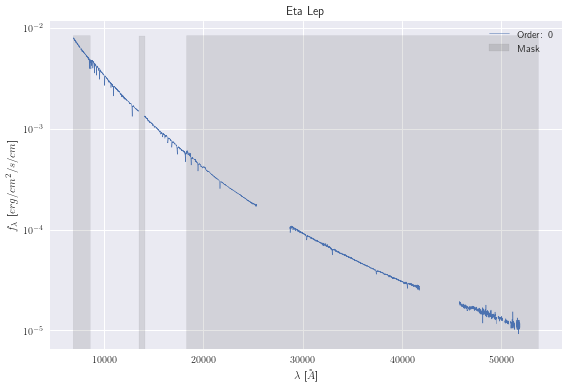

In [6]:
data.plot();

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](../api/models.rst#SpectrumModel).

Some of these parameters are based on guesses or pre-existing knowledge. In particular, it's important to tune `log_scale` to a reasonable value, so take some iterations of plotting against the data to get a good starting point. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

Starting with the [Simbad entry for our star](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=eta+lep&submit=SIMBAD+search) we track down some good initial values.

In [7]:
from Starfish.models import SpectrumModel

model = SpectrumModel(
    "F_SPEX_emu.hdf5",
    data,
    grid_params=[7000, 4.1, -0.06],
    Av=0,
    global_cov=dict(log_amp=28, log_ls=4),
)
model

/Users/miles/dev/starfish/Starfish/emulator/emulator.py:190: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as base:


SpectrumModel
-------------
Data: Eta Lep
Emulator: F_SPEX_emu
Log Likelihood: None

Parameters
  Av: 0
  T: 7000
  Z: -0.06
  global_cov:
    log_amp: 28
    log_ls: 4
  logg: 4.1

In this plot, we can see the data and model in the left pane, the absolute errors (residuals) along with the diagonal of the covariance matrix as $\sigma$ contours in the top-right, and the relative errors (residuals / flux) in the bottom-right

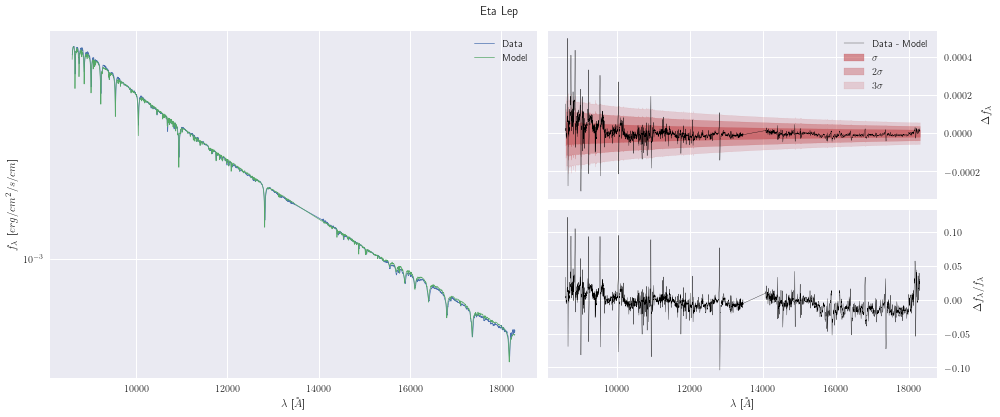

In [8]:
model.plot();

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. 


Here we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze](../api/models.rst#parametrization) mechanics. This is equivalent to applying a $\delta$-function prior.

In [9]:
# These are the fittable parameters
model.freeze("logg")
model.labels

('Av', 'T', 'Z', 'global_cov:log_amp', 'global_cov:log_ls')

Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [10]:
import scipy.stats as st

priors = {
    "T": st.uniform(6500, 1000),
    "Z": st.uniform(-0.5, 1.0),
    "Av": st.uniform(0, 2),
    "global_cov:log_amp": st.norm(28, 1),
    "global_cov:log_ls": st.uniform(0, 20)
}

Using the above priors, we can do our MAP optimization using `scipy.optimize.minimze`, which is usefully baked into the `train` method of our model. This should give us a good starting point for our MCMC sampling later. 

In [11]:
%time model.train(priors)

CPU times: user 19min 29s, sys: 5min 16s, total: 24min 45s
Wall time: 10min 55s


 final_simplex: (array([[ 6.26376007e-13,  7.10603581e+03, -5.29951805e-02,
         2.83861815e+01,  4.59977212e+00],
       [ 2.35190265e-13,  7.10603588e+03, -5.29951795e-02,
         2.83861814e+01,  4.59977212e+00],
       [ 2.98223621e-13,  7.10603581e+03, -5.29951826e-02,
         2.83861814e+01,  4.59977201e+00],
       [ 7.99380325e-13,  7.10603583e+03, -5.29951806e-02,
         2.83861814e+01,  4.59977210e+00],
       [ 9.37613462e-13,  7.10603581e+03, -5.29951804e-02,
         2.83861815e+01,  4.59977213e+00],
       [ 6.59551235e-13,  7.10603578e+03, -5.29951807e-02,
         2.83861816e+01,  4.59977212e+00]]), array([-47436.31576481, -47436.31576481, -47436.31576481, -47436.31576481,
       -47436.31576481, -47436.31576481]))
           fun: -47436.315764809995
       message: 'Optimization terminated successfully.'
          nfev: 529
           nit: 308
        status: 0
       success: True
             x: array([ 6.26376007e-13,  7.10603581e+03, -5.29951805e-02,  2.838

In [12]:
model

SpectrumModel
-------------
Data: Eta Lep
Emulator: F_SPEX_emu
Log Likelihood: 47447.90590614879

Parameters
  Av: 6.263760065275432e-13
  T: 7106.035806202933
  Z: -0.052995180547429306
  global_cov:
    log_amp: 28.386181492294547
    log_ls: 4.599772119901535

Frozen Parameters
  logg: 4.1

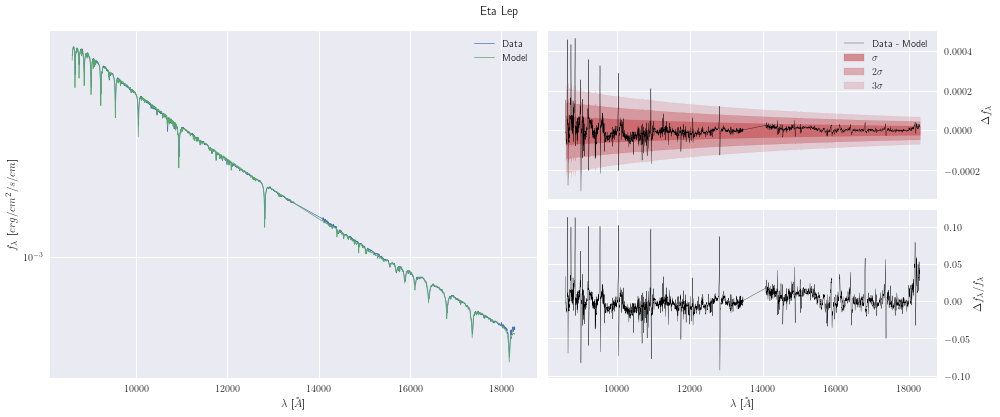

In [13]:
model.plot();

In [14]:
model.save("etalep_MAP.toml")

In [67]:
from Starfish.models.utils import find_residual_peaks, optimize_residual_peaks

peaks = find_residual_peaks(model)

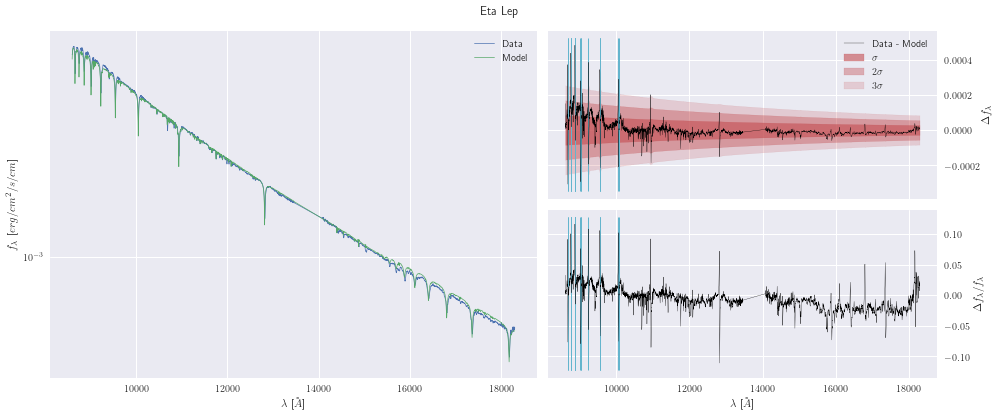

In [68]:
axes = model.plot()
lim1 = axes[1].get_ylim()
lim2 = axes[2].get_ylim()
for peak in peaks:
    axes[1].vlines(peak, *lim1, lw=1, color="C5")
    axes[2].vlines(peak, *lim2, lw=1, color="C5")

Now, we take these peaks and run them through an optimization scheme that fits the residuals (top right plot) with gaussians, and instantiates a kernel at each. If the fit kernel has too small of an amplitude, it is removed from the output. This can be useful in cases where sampling over each local kernel is too detrimental to the run time, especially considering they are an optional nuisance parameter.

In [69]:
local = optimize_residual_peaks(model, peaks)
model["local_cov"] = local

/Users/miles/dev/starfish/Starfish/models/utils.py:115: RuntimeWarning: overflow encountered in square
  gauss = _amp * np.exp(-0.5 * (rr / _sigma) ** 2)
/Users/miles/.pyenv/versions/3.7.0/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/miles/dev/starfish/Starfish/models/utils.py:115: RuntimeWarning: divide by zero encountered in true_divide
  gauss = _amp * np.exp(-0.5 * (rr / _sigma) ** 2)
/Users/miles/dev/starfish/Starfish/models/utils.py:115: RuntimeWarning: overflow encountered in true_divide
  gauss = _amp * np.exp(-0.5 * (rr / _sigma) ** 2)


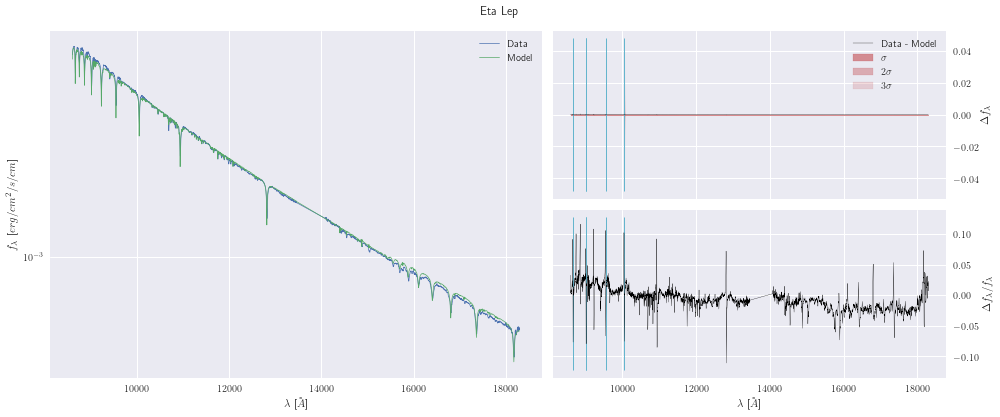

In [70]:
axes = model.plot()
lim1 = axes[1].get_ylim()
lim2 = axes[2].get_ylim()
for kernel in local:
    axes[1].vlines(kernel["mu"], *lim1, lw=1, color="C5")
    axes[2].vlines(kernel["mu"], *lim2, lw=1, color="C5")

Now, let's save a snapshot of our model before we begin sampling

In [71]:
model.save("etalep_MAP.toml")

## MCMC Sampling

Now, we will sample from our model. Note the flexibility we provide with *Starfish* in order to allow sampler front-end that allows blackbox likelihood methods. In our case, we will continue with [emcee](https://github.com/dfm/emcee), which provides an ensemble sampler. We are using pre-release of version `3.0`. This document serves only as an example, and details about emcee's usage should be sought after in its [documentation](https://emcee.readthedocs.io/en/latest/).

For this basic example, I will freeze both the global and local covariance parameters, so we are only sampling over `T`, `Z`, and `Av`.

In [15]:
import emcee
emcee.__version__

'3.0.0'

In [17]:
model.load("etalep_MAP.toml")
model.freeze(["global_cov", "logg"])

In [18]:
# Set our walkers and dimensionality
nwalkers = 50
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {
    "T": 1,
    "Z": 0.01,
    "Av": 0.01,
}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

In [19]:
# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)


# Set up our backend and sampler
backend = emcee.backends.HDFBackend("etalep_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, and following [this example](https://emcee.readthedocs.io/en/latest/tutorials/monitor/#saving-monitoring-progress) we check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This is something that can take many hours to complete. We recommend using a server to complete these computations. An ideal setup would have a jupyter server running such that we can avoid writing any scripts and transferring any data.

</div>

In [20]:
max_n = 1000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf


# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 10/1000 [03:04<5:14:30, 19.06s/it]/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/miles/.pyenv/versions/3.7.4/P

After our model has converged, let's take a few extra samples to make sure we have clean chains

In [21]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True);

100%|██████████| 100/100 [41:33<00:00, 24.93s/it]


## MCMC Chain Analysis

Chain analysis is a very broad topic that is mostly out of the scope of this example. 
For our analysis, we like using [ArviZ](https://github.com/arviz-devs/arviz) with a simple [corner](https://github.com/dfm/corner.py) plot as well. 

In [24]:
import arviz as az
import corner

print(az.__version__, corner.__version__)

0.6.0 1.0.3


In [25]:
reader = emcee.backends.HDFBackend("etalep_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


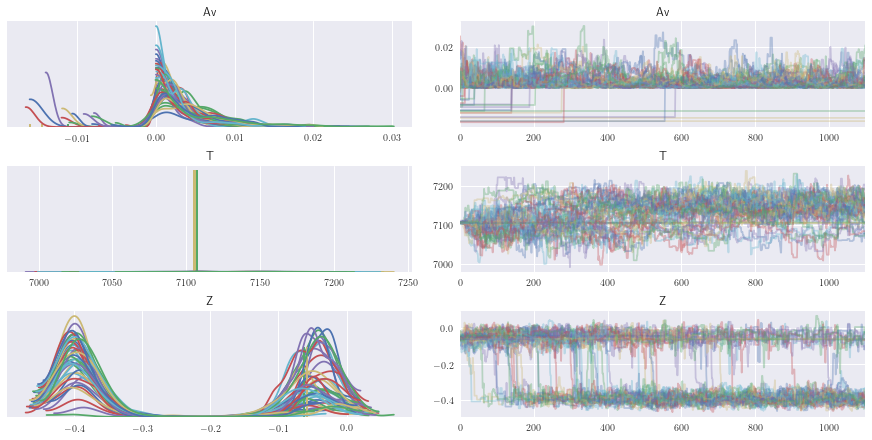

In [26]:
az.plot_trace(full_data);

After seeing our full traces, let's discard and thin some of the burn-in

In [37]:
burnin = 600
thin = 2
burn_samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


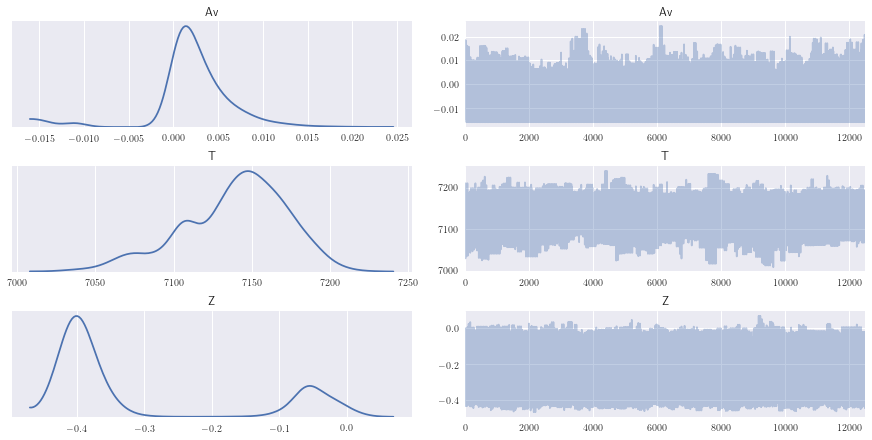

In [38]:
az.plot_trace(burn_data);

In [39]:
az.summary(burn_data)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12500), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Av,0.002,0.005,-0.011,0.011,0.000,0.000,12917.0,12917.0,12033.0,12105.0,NaN
T,7138.530,33.567,7069.448,7195.065,0.287,0.203,13663.0,13663.0,13672.0,13347.0,NaN
Z,-0.310,0.152,-0.440,-0.019,0.001,0.001,12912.0,12912.0,14451.0,12608.0,NaN


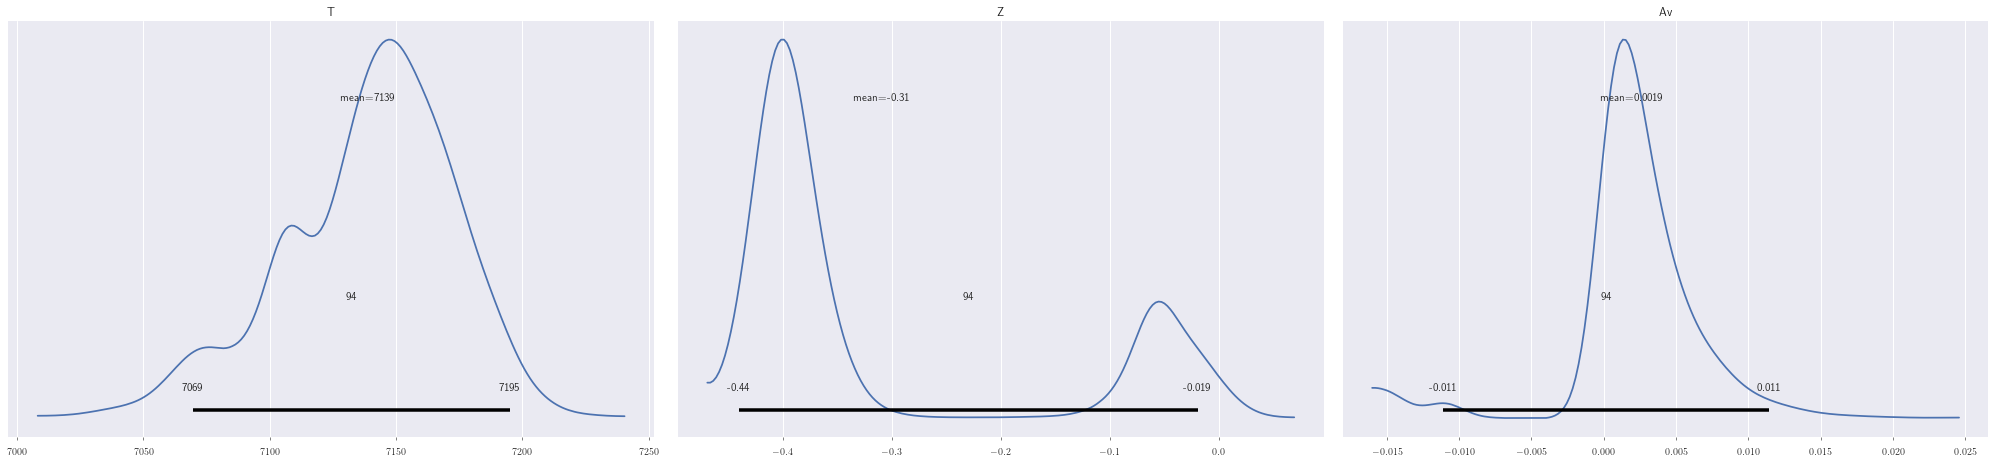

In [40]:
az.plot_posterior(burn_data, ["T", "Z", "Av"]);

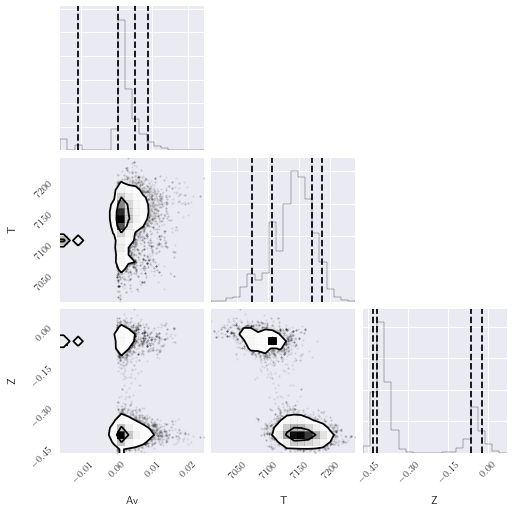

In [41]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples, labels=model.labels, quantiles=(0.05, 0.16, 0.84, 0.95), levels=sigmas
);

After looking at our posteriors, let's look at our fit

In [42]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12500), minimum_shape: (chains=2, draws=4)


SpectrumModel
-------------
Data: Eta Lep
Emulator: F_SPEX_emu
Log Likelihood: 47452.1671498983

Parameters
  Av: 0.002
  T: 7138.53
  Z: -0.31

Frozen Parameters
  logg: 4.1
  global_cov:log_amp: 28.386181492294547
  global_cov:log_ls: 4.599772119901535

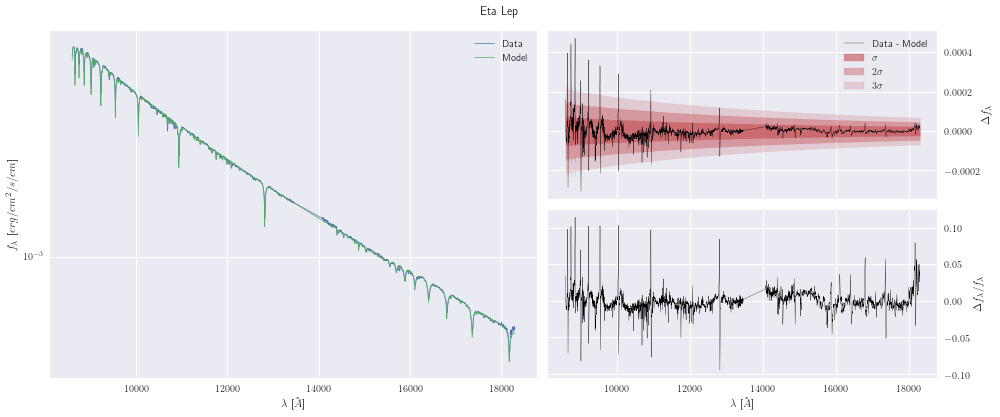

In [43]:
model.plot();

and finally, we can save our best fit.

In [44]:
model.save("etalep_sampled.toml")

Now, on to the next star!